In [1]:
from lsst.daf.persistence import Butler

In [2]:
butler = Butler('/home/shared/twinkles/output_data_v2')

In [3]:
subset = butler.subset('calexp', filter='r')

In [4]:
subset.cache

[{'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 230},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 231},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 232},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 233},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 234},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 236},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 237},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 238},
 {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 239}]

In [5]:
dataid = subset.cache[6]
my_calexp = butler.get('calexp', **dataid)

In [6]:
my_calexp

In [7]:
psf = my_calexp.getPsf()

In [8]:
shape = psf.computeShape()

In [9]:
shape.getDeterminantRadius() # Units are pixels, documentation

2.211816547143532

In [10]:
help(psf.computeShape)

Help on method computeShape in module lsst.afw.detection._psf:

computeShape(...) method of lsst.meas.extensions.psfex.psfexPsf.PsfexPsf instance
    computeShape(self: lsst.afw.detection._psf.Psf, position: lsst.afw.geom.coordinates.coordinates.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x7fc472630b58>) -> lsst.afw.geom.ellipses._quadrupole.Quadrupole



In [11]:
from lsst.afw.geom import Point2D

In [12]:
point = Point2D(50., 100.)
point

Point2D(50, 100)

In [13]:
my_calexp.getDimensions()

Extent2I(4000, 4072)

In [14]:
import numpy as np

In [15]:
n = 10000
x_array = np.random.uniform(0, my_calexp.getDimensions()[0], n)
y_array = np.random.uniform(0, my_calexp.getDimensions()[1], n)

In [16]:
shapes = np.empty(n)
for ii, (x, y) in enumerate(zip(x_array, y_array)):
    point = Point2D(x, y)
    shape = psf.computeShape(point)
    shapes[ii] = shape.getDeterminantRadius()

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

(array([2759., 2298., 1712., 1301.,  862.,  502.,  292.,  148.,   92.,
          34.]),
 array([2.21124745, 2.21535402, 2.21946058, 2.22356714, 2.22767371,
        2.23178027, 2.23588683, 2.2399934 , 2.24409996, 2.24820653,
        2.25231309]),
 <a list of 10 Patch objects>)

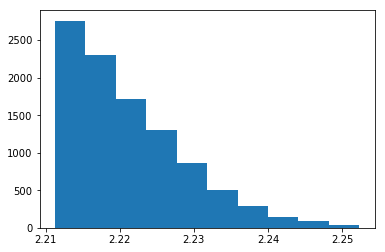

In [39]:
plt.hist(shapes)

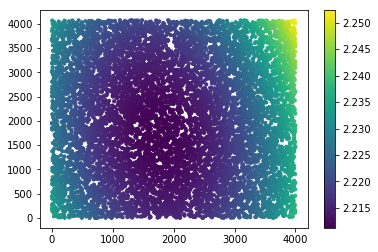

In [40]:
plt.scatter(x_array, y_array, c=shapes, s=10)
plt.colorbar()

In [20]:
my_src = butler.get('src', **dataid)
my_src.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psfCandidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psfUsed", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Field[

In [41]:
np.sum(my_src.get('calib_psfCandidate')) # Number of stars used for PSF fitting

113

In [42]:
star_idx = np.where(my_src.get('base_ClassificationExtendedness_value') == 0)[0]

In [65]:
star_shape = []
psf_shape = []
for x, y in zip(my_src.getX()[star_idx], my_src.getY()[star_idx]):
    point = Point2D(x, y)
    psf_shape.append(psf.computeShape(point).getDeterminantRadius())
for xx, yy in zip(my_src.get('base_SdssShape_xx')[star_idx], my_src.get('base_SdssShape_yy')[star_idx]):    
    star_shape.append(np.sqrt(xx + yy))
star_shape = np.array(star_shape)
psf_shape = np.array(psf_shape)
cut = np.isfinite(star_shape) & np.isfinite(psf_shape)
star_shape = star_shape[cut]
psf_shape = psf_shape[cut]

(0.5, 1.0)

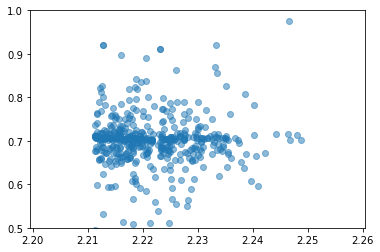

In [66]:
plt.scatter(psf_shape, np.array(psf_shape) / np.array(star_shape), alpha=0.5)
#plt.xlim(2., 5.)
plt.ylim(.5, 1.)

In [25]:
#plt.hist(psf_shape)
#plt.hist(star_shape)

In [67]:
np.median(psf_shape / star_shape)

0.7038454743471458

In [69]:
np.sqrt(2) / 2

0.7071067811865476